In [1]:
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as T

from ignite.engine import Engine, Events
from ignite.metrics import Average

import matplotlib.pyplot as plt

from modules import Generator, Discriminator
from models import DeepConvolutionGAN

# Data

## Dataloader

In [2]:
train_data = dsets.CIFAR10("./", download=True, transform=T.ToTensor())
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

Files already downloaded and verified


## Data arguments

In [3]:
input_size = 32

# Model

## Model arguments

In [4]:
latent_dim = 100
hidden_channel = 128
G_last_act = "sigmoid"

## Make model

In [5]:
generator = Generator(input_size=input_size, latent_dim=latent_dim, hidden_channel=hidden_channel, last_act=G_last_act)
discriminator = Discriminator(input_size=input_size, hidden_channel=hidden_channel)

In [6]:
model = DeepConvolutionGAN(
    generator=generator,
    generator_opt=torch.optim.Adam(generator.parameters(), 1e-4),
    discriminator=discriminator,
    discriminator_opt=torch.optim.Adam(discriminator.parameters(), 1e-4),
)

In [7]:
if torch.cuda.is_available():
    _ = model.cuda()

# Trainer

## Set Ignite Engine

In [8]:
trainer = Engine(model.fit_batch)

## Set metrics

In [9]:
from utils import output_transform

In [10]:
for key in ["G_loss", "D_loss"]:
    average = Average(output_transform=partial(output_transform, key=key))
    average.attach(trainer, key)

## Add event handlers

In [11]:
from utils.event_handlers import log_metric, print_img, print_metric

In [12]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_metric)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), print_metric)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), print_img, model)

## Run

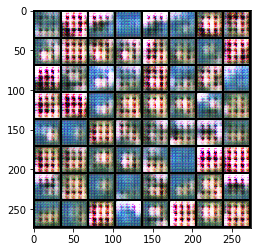

Epoch 5 - G_loss: 8.0956, D_loss: 0.0291, 


In [ ]:
trainer.run(train_loader, 50)